In [1]:
!pip install ipympl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Question 1- Part 1

In [1]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget 

import matplotlib.pyplot as plt # For general plotting

import numpy as np

from scipy.stats import multivariate_normal # MVN not univariate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

from google.colab import output
output.enable_custom_widget_manager()

In [2]:
N = 10000

mu = np.array([ [1.5, 0],
                [0, 1.5], 
                [2, 2] ])  # Gaussian distributions means
Sigma = np.array([[[1, 0],
                   [0, 0.5]],
                  [[0.5, 0],
                   [0, 1]],
                   [[1, 0],
                   [0, 1]] ])  # Gaussian distributions covariance matrices

# Determine dimensionality from mixture PDF parameters
n = mu.shape[1]
class_priors = np.array([0.65, 0.35])
C = len(class_priors)
L = np.array(range(C))

labels = np.random.rand(N) >= class_priors[0]
Nl = np.array([sum(labels == l) for l in L])

In [3]:
X = np.zeros([N, n])
X[labels == 0, :] =   multivariate_normal.rvs(mu[0], Sigma[0], Nl[0]) + multivariate_normal.rvs(mu[1], Sigma[1], Nl[0])
X[labels == 1, :] =  multivariate_normal.rvs(mu[2], Sigma[2], Nl[1])

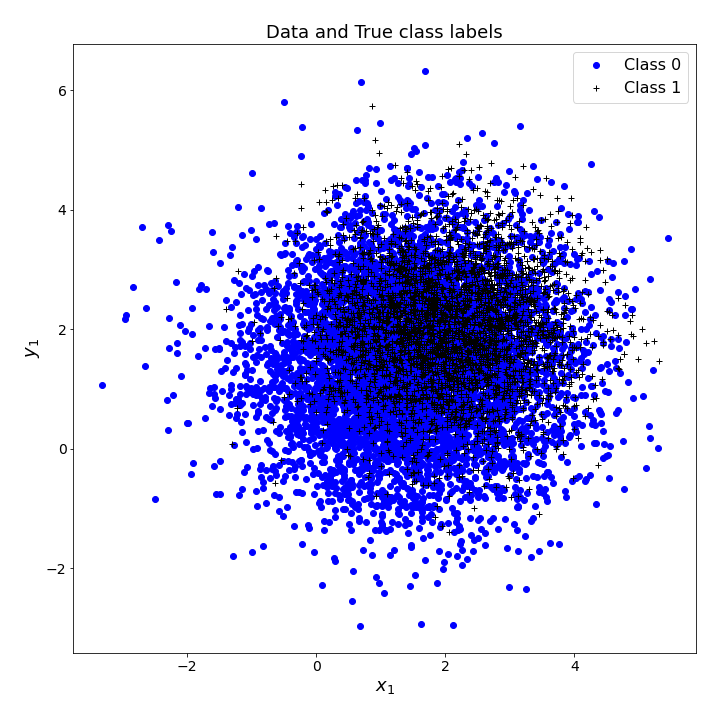

In [4]:
#plot
fig = plt.figure(figsize=(10,10))
plt.plot(X[labels==0, 0], X[labels==0, 1], 'bo', label="Class 0")
plt.plot(X[labels==1, 0], X[labels==1, 1], 'k+', label="Class 1")
plt.legend()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$y_1$')
plt.title('Data and True class labels')
plt.tight_layout()
plt.show()

In [5]:
print('Number of samples from class 1: {:d}, class 2: {:d}' .format(Nl[0], Nl[1]))
class_conditional_likelihoods = np.zeros([n,N])
class_conditional_likelihoods[0] = np.array([multivariate_normal.pdf(X, mu[0], Sigma[0])])  + np.array([multivariate_normal.pdf(X, mu[1], Sigma[1])])
class_conditional_likelihoods[1] = np.array([multivariate_normal.pdf(X, mu[2], Sigma[2])])

discriminant_score_erm = np.log(class_conditional_likelihoods[1]) - np.log(class_conditional_likelihoods[0])
gamma_map = class_priors[0]/ class_priors[1]

print(gamma_map)
print(discriminant_score_erm)

Number of samples from class 1: 6490, class 2: 3510
1.8571428571428574
[-0.7839428   5.28960256 -3.75738747 ...  2.33421339 -3.59756238
  4.04192295]


In [6]:
from sys import float_info
def estimate_roc(discriminant_score, label):
    Nlabels = np.array((sum(labels == 0), sum(labels == 1)))

    # Sorting necessary so the resulting FPR and TPR axes plot threshold probabilities in order as a line
    sorted_score = sorted(discriminant_score)

    # Use gamma values that will account for every possible classification split
    gammas = ([sorted_score[0] - float_info.epsilon] +
              sorted_score +
              [sorted_score[-1] + float_info.epsilon])

    # Calculate the decision label for each observation for each gamma
    decisions = [discriminant_score >= g for g in gammas]

    ind10 = [np.argwhere((d==1) & (label==0)) for d in decisions]
    p10 = [len(inds)/Nlabels[0] for inds in ind10]
    ind11 = [np.argwhere((d==1) & (label==1)) for d in decisions]
    p11 = [len(inds)/Nlabels[1] for inds in ind11]

    # ROC has FPR on the x-axis and TPR on the y-axis
    roc = {}
    roc['p10'] = np.array(p10)
    roc['p11'] = np.array(p11)

    return roc, gammas


def get_binary_classification_metrics(predictions, labels):
    N_labels = np.array((sum(labels == 0), sum(labels == 1)))

    # Get indices and probability estimates of the four decision scenarios:
    # (true negative, false positive, false negative, true positive)
    class_metrics = {}
    
    # True Negative Probability Rate
    ind_00 = np.argwhere((predictions == 0) & (labels == 0))
    class_metrics['TNR'] = len(ind_00) / N_labels[0]
    # False Positive Probability Rate
    ind_10 = np.argwhere((predictions == 1) & (labels == 0))
    class_metrics['FPR'] = len(ind_10) / N_labels[0]
    # False Negative Probability Rate
    ind_01 = np.argwhere((predictions == 0) & (labels == 1))
    class_metrics['FNR'] = len(ind_01) / N_labels[1]
    # True Positive Probability Rate
    ind_11 = np.argwhere((predictions == 1) & (labels == 1))
    class_metrics['TPR'] = len(ind_11) / N_labels[1]

    return class_metrics

In [7]:
roc_erm, gammas_empirical = estimate_roc(discriminant_score_erm, labels)

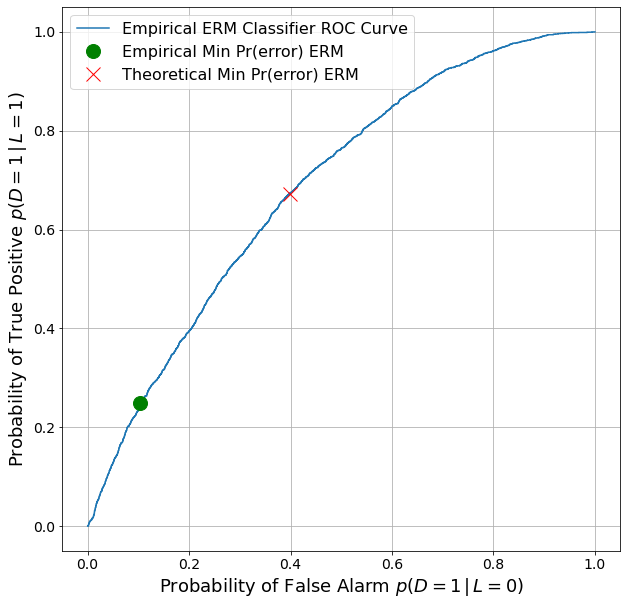

In [8]:
plt.ioff() # Interactive plotting off
fig_roc, ax_roc = plt.subplots(figsize=(10, 10));
plt.ion()

ax_roc.plot(roc_erm['p10'], roc_erm['p11'], label="Empirical ERM Classifier ROC Curve")
ax_roc.set_xlabel(r"Probability of False Alarm $p(D=1\,|\,L=0)$")
ax_roc.set_ylabel(r"Probability of True Positive $p(D=1\,|\,L=1)$")

N_per_l = np.array((sum(labels == 0), (sum(labels == 1))))
prob_error_empirical = np.array((roc_erm['p10'], 1 - roc_erm['p11'])).T.dot(N_per_l / N)
# Min prob error for the empirically-selected gamma thresholds
min_prob_error_empirical = np.min(prob_error_empirical)
min_ind_empirical = np.argmin(prob_error_empirical)

gamma_map = class_priors[0] / class_priors[1]
decisions_map = discriminant_score_erm >= np.log(gamma_map)

class_metrics_map = get_binary_classification_metrics(decisions_map, labels)
min_prob_error_map = np.array((class_metrics_map['FPR'] * class_priors[0] + 
                               class_metrics_map['FNR'] * class_priors[1]) )


# Plot theoretical and empirical
ax_roc.plot(roc_erm['p10'][min_ind_empirical], roc_erm['p11'][min_ind_empirical], 'go', label="Empirical Min Pr(error) ERM",
            markersize=14)
ax_roc.plot(class_metrics_map['FPR'], class_metrics_map['TPR'], 'rx', label="Theoretical Min Pr(error) ERM", markersize=14)
plt.legend()

plt.grid(True)
display(fig_roc)
fig_roc;

In [9]:
print("Min Empirical Pr(error) for ERM = {:.3f}".format(min_prob_error_empirical))
print("Min Empirical Gamma = {:.3f}".format(np.exp(gammas_empirical[min_ind_empirical])))

print("Min Theoretical Pr(error) for ERM = {:.3f}".format(min_prob_error_map))
print("Min Theoretical Gamma = {:.3f}".format(gamma_map))

Min Empirical Pr(error) for ERM = 0.331
Min Empirical Gamma = 64.150
Min Theoretical Pr(error) for ERM = 0.373
Min Theoretical Gamma = 1.857


#Question 1-Part 2

In [2]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget 

import matplotlib.pyplot as plt # For general plotting
from matplotlib import cm

from math import ceil, floor 

import numpy as np
import seaborn as sns
from scipy.stats import norm, multivariate_normal

np.set_printoptions(suppress=True)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

In [3]:
# (2a)
np.random.seed(7)
N_train = [20, 200, 2000]
N_valid = 10000


In [4]:
def generate_data_from_gmm(N, pdf_params, fig_ax=None):
    # Determine dimensionality from mixture PDF parameters
    n = pdf_params['mu'].shape[1]
    # Determine number of classes/mixture components
    C = len(pdf_params['priors'])

    # Output samples and labels
    X = np.zeros([N, n])
    labels = np.zeros(N)
    
    # Decide randomly which samples will come from each component u_i ~ Uniform(0, 1) for i = 1, ..., N (or 0, ... , N-1 in code)
    u = np.random.rand(N)
    # Determine the thresholds based on the mixture weights/priors for the GMM, which need to sum up to 1
    thresholds = np.cumsum(pdf_params['priors'])
    thresholds = np.insert(thresholds, 0, 0) # For intervals of classes

    marker_shapes = 'ox+*.' # Accomodates up to C=5
    marker_colors = 'brgmy'
    Y = np.array(range(1, C+1))
    for y in Y:
        # Get randomly sampled indices for this component
        indices = np.argwhere((thresholds[y-1] <= u) & (u <= thresholds[y]))[:, 0]
        # No. of samples in this component
        Ny = len(indices)  
        #print(Ny)
        labels[indices] = y * np.ones(Ny) - 1
        if n == 1:
            X[indices, 0] =  norm.rvs(pdf_params['mu'][y+1], pdf_params['Sigma'][y+1], Ny)
        else:
            X[indices, :] =  multivariate_normal.rvs(pdf_params['mu'][y-1], pdf_params['Sigma'][y-1], Ny) + multivariate_normal.rvs(pdf_params['mu'][y], pdf_params['Sigma'][y], Ny)
                
    if fig_ax and (0 < n <= 3):
        if n == 1:
            fig_ax.scatter(X, np.zeros(N), c=labels)
        elif n == 2:
            fig_ax.scatter(X[:, 0], X[:, 1], c=labels)
            fig_ax.set_ylabel(r"$x_2$")
            fig_ax.set_aspect('equal')
        else:
            fig_ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels)
            fig_ax.set_ylabel(r"$x_2$")
            fig_ax.set_zlabel(r"$x_3$")
            # Setting equal aspect ratio for 3D plots (ptp for range of values)
            fig_ax.set_box_aspect((np.ptp(X[:, 0]), np.ptp(X[:, 1]), np.ptp(X[:, 2])))

        fig_ax.set_xlabel(r"$x_1$")

    
    return X, labels

In [21]:
#!pip install matplotlib==2.2.3

Generating the training data set; Ntrain = 20
Generating the training data set; Ntrain = 200
Generating the training data set; Ntrain = 2000
Label counts for training sets:  [array([13,  7]), array([131,  69]), array([1312,  688])]
Label counts for validation set:  [6486 3514]


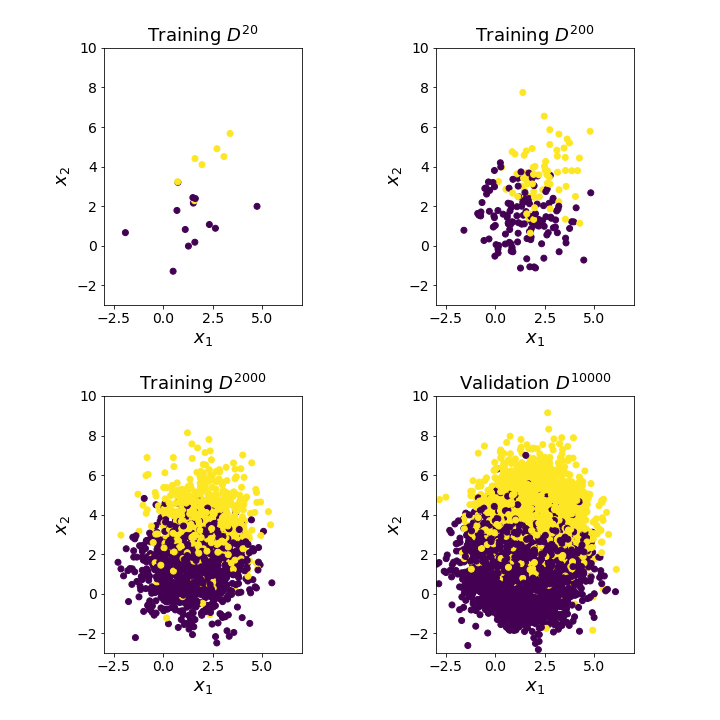

In [5]:
from math import ceil, floor
import matplotlib.pyplot as plt
from google.colab import output
output.enable_custom_widget_manager()
gmm_pdf = {}
# Likelihood of each distribution to be selected AND class priors!!!
gmm_pdf['priors'] = np.array([0.65, 0.35])  
gmm_pdf['mu'] = np.array([ [1.5, 0],
                [0, 1.5], 
                [2, 2] ])  # Gaussian distributions means

gmm_pdf['Sigma'] = np.array([[[1, 0],
                   [0, 0.5]],
                  [[0.5, 0],
                   [0, 1]],
                   [[1, 0],
                   [0, 1]] ])  # Gaussian distributions covariance matrices

# Create figure outside the generate GMM function, but populate axes within sampling function
fig, ax = plt.subplots(2, 2, figsize=(10, 10))


# Lists to hold the corresponding input matrices, target vectors and sample label counts per training set
X_train = []
y_train = []
Ny_train = []

# Index for axes
t = 0
for N_t in N_train:
    print("Generating the training data set; Ntrain = {}".format(N_t))
    
    # Modulus to plot in right locations, hacking it
    X_t, y_t = generate_data_from_gmm(N_t, gmm_pdf, fig_ax= ax[floor(t/2), t%2])
    ax[floor(t/2), t%2].set_title(r"Training $D^{%d}$" % (N_t))
    t += 1

    # Prepend column of ones to create augmented inputs tilde{x}
    X_t = np.column_stack((np.ones(N_t), X_t))  
    n = X_t.shape[1]

    Ny_t = np.array((sum(y_t == 0), sum(y_t == 1)))
    
    # Add to lists
    X_train.append(X_t)
    y_train.append(y_t)
    Ny_train.append(Ny_t)

print("Label counts for training sets: ", Ny_train)

# Also generate validation dataset from GMM!
X_valid, y_valid = generate_data_from_gmm(N_valid, gmm_pdf, fig_ax = ax[1, 1])
# Prepend column of ones to create augmented inputs tilde{x}
X_valid = np.column_stack((np.ones(N_valid), X_valid))  
ax[1, 1].set_title(r"Validation $D^{%d}$" % (N_valid))
        
Ny_valid = np.array((sum(y_valid == 0), sum(y_valid == 1)))
print("Label counts for validation set: ", Ny_valid)

# Using validation set samples to limit axes (most samples drawn, highest odds of spanning sample space)
x1_valid_lim = (floor(np.min(X_valid[:,1])), ceil(np.max(X_valid[:,1])))
x2_valid_lim = (floor(np.min(X_valid[:,2])), ceil(np.max(X_valid[:,2])))
plt.setp(ax, xlim=x1_valid_lim, ylim=x2_valid_lim)
plt.tight_layout()
plt.show()

fig;

In [32]:
n = gmm_pdf['mu'].shape[1]
print(n)

2


In [6]:
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))
def predict_prob(X, w):
    logits = X.dot(w)
    return sigmoid(logits)

In [7]:
def log_reg_loss(w, X, y):
    # Size of batch
    B = X.shape[0]

    # Logistic regression model g(X * w)
    predictions = predict_prob(X, w)

    # NLL loss, 1/N sum [y*log(g(X*w)) + (1-y)*log(1-g(X*w))]
    error = predictions - y
    nll = -np.mean(y*np.log(predictions) + (1 - y)*np.log(1 - predictions))
    
    # Partial derivative for GD
    gradient = (1 / B) * X.T.dot(error)
    
    # Logistic regression loss, NLL (binary cross entropy is another interpretation)
    return nll, gradient


# Options for mini-batch gradient descent
opts = {}
opts['max_epoch'] = 100
opts['alpha'] = 0.05
opts['tolerance'] = 1e-3

opts['batch_size'] = 10

# Breaks the matrix X and vector y into batches
def batchify(X, y, batch_size, N):
    shuffled_indices = np.random.permutation(N) # Returns a permutation of indices up to N

    # Shuffle row-wise X (i.e. across training examples) and labels using same permuted order
    X = X[shuffled_indices]
    y = y[shuffled_indices]

    X_batch = []
    y_batch = []

    # Iterate over N in batch_size steps, last batch may be < batch_size
    for i in range(0, N, batch_size):
        nxt = min(i + batch_size, N + 1)
        X_batch.append(X[i:nxt, :])
        y_batch.append(y[i:nxt])

    return X_batch, y_batch


def gradient_descent(loss_func, theta0, X, y, N, *args, **kwargs):
    # Mini-batch GD. Stochastic GD if batch_size=1.

    # Break up data into batches and work out gradient for each batch
    # Move parameters theta in that direction, scaled by the step size.

    # Options for total sweeps over data (max_epochs),
    # and parameters, like learning rate and threshold.

    # Default options
    max_epoch = kwargs['max_epoch'] if 'max_epoch' in kwargs else 200
    alpha = kwargs['alpha'] if 'alpha' in kwargs else 0.1
    epsilon = kwargs['tolerance'] if 'tolerance' in kwargs else 1e-6

    batch_size = kwargs['batch_size'] if 'batch_size' in kwargs else 10

    # Turn the data into batches
    X_batch, y_batch = batchify(X, y, batch_size, N)
    num_batches = len(y_batch)
    print("%d batches of size %d\n" % (num_batches, batch_size))

    theta = theta0
    m_t = np.zeros(theta.shape)

    trace = {}
    trace['loss'] = []
    trace['theta'] = []

    # Main loop:
    for epoch in range(1, max_epoch + 1):
        # print("epoch %d\n" % epoch)
        
        loss_epoch = 0
        for b in range(num_batches):
            X_b = X_batch[b]
            y_b = y_batch[b]
            # print("epoch %d batch %d\n" % (epoch, b))

            # Compute NLL loss and gradient of NLL function
            loss, gradient = loss_func(theta, X_b, y_b, *args)
            loss_epoch += loss
            
            # Steepest descent update
            theta = theta - alpha * gradient
            
            # Terminating Condition is based on how close we are to minimum (gradient = 0)
            if np.linalg.norm(gradient) < epsilon:
                print("Gradient Descent has converged after {} epochs".format(epoch))
                break
                
        # Storing the history of the parameters and loss values per epoch
        trace['loss'].append(np.mean(loss_epoch))
        trace['theta'].append(theta)
        
        # Also break epochs loop
        if np.linalg.norm(gradient) < epsilon:
            break

    return theta, trace


In [8]:
# Can also use: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html
def quadratic_transformation(X):    
    # Take all monic polynomials for a quadratic
    phi_X = np.column_stack((X, X[:, 1]**2, X[:, 1] * X[:, 2], X[:, 2]**2))
        
    return phi_X

In [9]:
# Use the validation set's sample space to bound the grid of inputs
# Work out bounds that span the input feature space (x_1 and x_2)
bounds_X = np.array((floor(np.min(X_valid[:,1])), ceil(np.max(X_valid[:,1]))))
bounds_Y = np.array((floor(np.min(X_valid[:,2])), ceil(np.max(X_valid[:,2]))))

def create_prediction_score_grid(w, poly_type='L'):
    # Create coordinate matrices determined by the sample space; can add finer intervals than 100 if desired
    xx, yy = np.meshgrid(np.linspace(bounds_X[0], bounds_X[1], 200), np.linspace(bounds_Y[0], bounds_Y[1], 200))

    # Augment grid space with bias ones vector and basis expansion if necessary
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_aug = np.column_stack((np.ones(200*200), grid)) 
    if poly_type == 'Q':
        grid_aug = quadratic_transformation(grid_aug)

    # Z matrix are the predictions resulting from sigmoid on the provided model parameters
    Z = predict_prob(grid_aug, w).reshape(xx.shape)
    
    return xx, yy, Z


def plot_prediction_contours(X, w, ax, poly_type='L'):
    xx, yy, Z = create_prediction_score_grid(w, poly_type)
    # Once reshaped as a grid, plot contour of probabilities per input feature (ignoring bias)
    cs = ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.55)
    ax.set_xlim([bounds_X[0], bounds_X[1]])
    ax.set_ylim([bounds_Y[0], bounds_Y[1]])

    
def plot_decision_boundaries(X, labels, w, ax, poly_type='L'): 
    # Plots original class labels and decision boundaries
    ax.plot(X[labels==0, 1], X[labels==0, 2], 'o', label="Class 0")
    ax.plot(X[labels==1, 1], X[labels==1, 2], '+', label="Class 1")
    
    xx, yy, Z = create_prediction_score_grid(w, poly_type)
    # Once reshaped as a grid, plot contour of probabilities per input feature (ignoring bias)
    cs = ax.contour(xx, yy, Z, levels=1, colors='k')

    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$")
    ax.set_aspect('equal')

    
def report_logistic_classifier_results(X, w, labels, N_labels, ax, poly_type='L'):
    """
    Report the probability of error and plot the classified data, plus predicted 
    decision contours of the logistic classifier applied to the data given.
    """
    
    predictions = predict_prob(X, w)  
    # Predicted decisions based on the default 0.5 threshold (higher probability mass on one side or the other)
    decisions = np.array(predictions >= 0.5)
    
    # True Negative Probability Rate
    ind_00 = np.argwhere((decisions == 0) & (labels == 0))
    tnr = len(ind_00) / N_labels[0]
    # False Positive Probability Rate
    ind_10 = np.argwhere((decisions == 1) & (labels == 0))
    fpr = len(ind_10) / N_labels[0]
    # False Negative Probability Rate
    ind_01 = np.argwhere((decisions == 0) & (labels == 1))
    fnr = len(ind_01) / N_labels[1]
    # True Positive Probability Rate
    ind_11 = np.argwhere((decisions == 1) & (labels == 1))
    tpr = len(ind_11) / N_labels[1]

    prob_error = fpr*gmm_pdf['priors'][0] + fnr*gmm_pdf['priors'][1]

    print("The total error achieved with this classifier is {:.3f}".format(prob_error))
    
    # Plot all decisions (green = correct, red = incorrect)
    ax.plot(X[ind_00, 1], X[ind_00, 2], 'og', label="Class 0 Correct", alpha=.25)
    ax.plot(X[ind_10, 1], X[ind_10, 2], 'or', label="Class 0 Wrong")
    ax.plot(X[ind_01, 1], X[ind_01, 2], '+r', label="Class 1 Wrong")
    ax.plot(X[ind_11, 1], X[ind_11, 2], '+g', label="Class 1 Correct", alpha=.25)

    # Draw the decision boundary based on whether its linear (L) or quadratic (Q)
    plot_prediction_contours(X, w, ax, poly_type)
    ax.set_aspect('equal')

#Question1- Part 2(a)

Training the logistic-linear model with GD per data subset
2 batches of size 10

Logistic-Linear N=20 GD Theta: [-1.87477841 -0.31432833  0.87168955]
Logistic-Linear N=20 NLL: 0.6985361165826667
The total error achieved with this classifier is 0.235
20 batches of size 10

Logistic-Linear N=200 GD Theta: [-4.22415092  0.51370245  1.14630147]
Logistic-Linear N=200 NLL: 7.461876416562347
The total error achieved with this classifier is 0.197
200 batches of size 10

Logistic-Linear N=2000 GD Theta: [-4.35870012  0.27885243  1.34147346]
Logistic-Linear N=2000 NLL: 79.38116713475202
The total error achieved with this classifier is 0.192


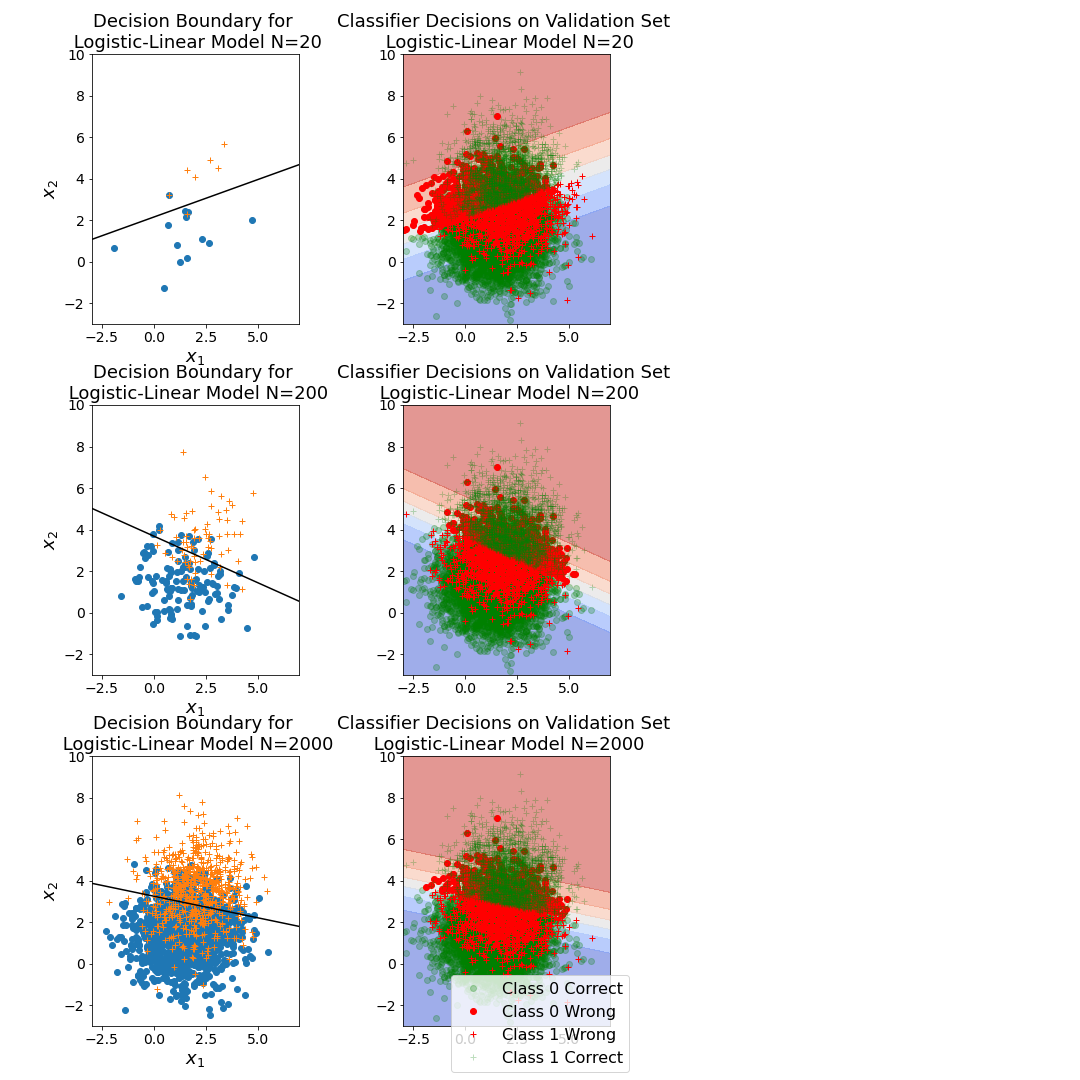

In [10]:
# Starting point from to search for optimal parameters
theta0_linear = np.random.randn(n)

fig_decision, ax_decision = plt.subplots(3, 2, figsize=(15, 15));

print("Training the logistic-linear model with GD per data subset"),
for i in range(len(N_train)):
    theta_gd, trace = gradient_descent(log_reg_loss, theta0_linear, X_train[i], y_train[i], N_train[i], **opts)

    print("Logistic-Linear N={} GD Theta: {}".format(N_train[i], theta_gd))
    print("Logistic-Linear N={} NLL: {}".format(N_train[i], trace['loss'][-1]))

    # Convert our trace of parameter and loss function values into NumPy "history" arrays:
    theta_hist = np.asarray(trace['theta'])
    nll_hist = np.array(trace['loss'])
    
    plot_decision_boundaries(X_train[i], y_train[i], theta_gd, ax_decision[i, 0])
    ax_decision[i, 0].set_title("Decision Boundary for \n Logistic-Linear Model N={}".format(N_train[i]))

    # Linear: use validation data (10k samples) and make decisions in report results routine
    report_logistic_classifier_results(X_valid, theta_gd, y_valid, Ny_valid, ax_decision[i, 1])
    ax_decision[i, 1].set_title("Classifier Decisions on Validation Set \n Logistic-Linear Model N={}".format(N_train[i]))

# Again use the most sampled subset (validation) to define x-y limits
plt.setp(ax_decision, xlim=x1_valid_lim, ylim=x2_valid_lim)

# Adjust subplot positions
plt.subplots_adjust(left=0.05,
                    bottom=0.05, 
                    right=0.6, 
                    top=0.95, 
                    wspace=0.1, 
                    hspace=0.3)

# Super plot the legends
handles, labels = ax_decision[0, 1].get_legend_handles_labels()
fig_decision.legend(handles, labels, loc='lower center')

plt.show()

#Question1- Part2(b)

Training the logistic-quadratic model with GD per data subset
2 batches of size 10

Logistic-Quadratic N=20 GD Theta: [-1.29453007 -0.73718649 -2.53630153 -0.35612226  1.07344472  0.75494177]
Logistic-Quadratic N=20 NLL: 0.6350244456297762
The total error achieved with this classifier is 0.206
20 batches of size 10

Logistic-Quadratic N=200 GD Theta: [-1.80090742 -0.04083784 -0.96300417 -0.25127248  0.6462221   0.16848149]
Logistic-Quadratic N=200 NLL: 7.734363711567866


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in multiply
  # Remove the CWD from sys.path while we load stuff.


The total error achieved with this classifier is 0.217
200 batches of size 10

Logistic-Quadratic N=2000 GD Theta: [-3.32608215  0.09060076  0.24152987 -0.01567365  0.1425677   0.36362883]
Logistic-Quadratic N=2000 NLL: 88.97746740463143
The total error achieved with this classifier is 0.222


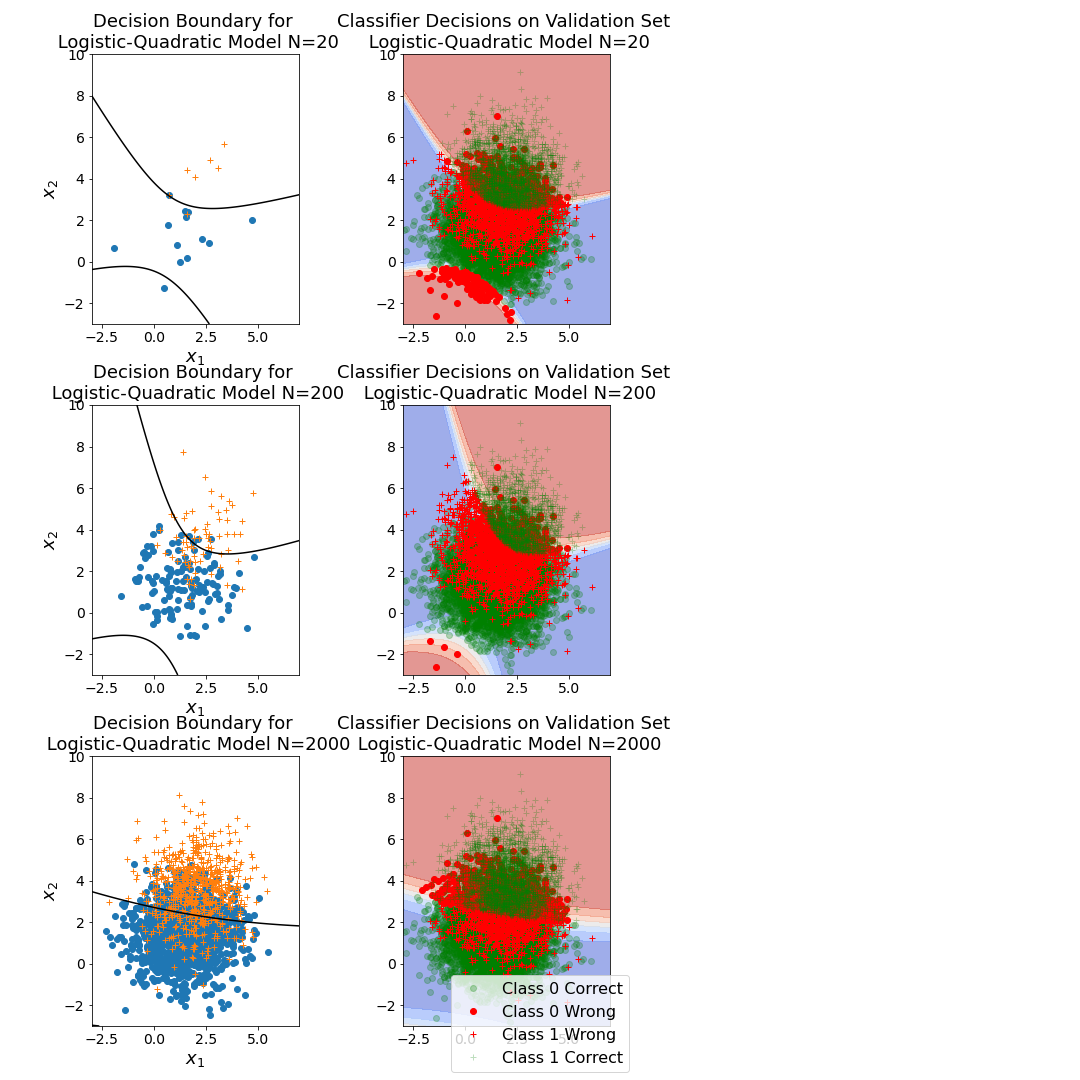

In [11]:
# NOTE that the initial parameters have added dimensionality to match the basis expansion set
theta0_quadratic = np.random.randn(n+3)

fig_decision, ax_decision = plt.subplots(3, 2, figsize=(15, 15));

print("Training the logistic-quadratic model with GD per data subset"),
for i in range(len(N_train)):
    # Important transformation line to add monic polynomial terms for a quadratic
    X_quad = quadratic_transformation(X_train[i])
    theta_gd, trace = gradient_descent(log_reg_loss, theta0_quadratic, X_quad, y_train[i], N_train[i], **opts)

    print("Logistic-Quadratic N={} GD Theta: {}".format(N_train[i], theta_gd))
    print("Logistic-Quadratic N={} NLL: {}".format(N_train[i], trace['loss'][-1]))

    # Convert our trace of parameter and loss function values into NumPy "history" arrays:
    theta_hist = np.asarray(trace['theta'])
    nll_hist = np.array(trace['loss'])
    
    plot_decision_boundaries(X_quad, y_train[i], theta_gd, ax_decision[i, 0], poly_type='Q')
    ax_decision[i, 0].set_title("Decision Boundary for \n Logistic-Quadratic Model N={}".format(N_train[i]))

    # Quadratic: use validation data (10k samples) and make decisions in report results routine
    X_valid_quad = quadratic_transformation(X_valid)
    report_logistic_classifier_results(X_valid_quad, theta_gd, y_valid, Ny_valid, ax_decision[i, 1], poly_type='Q')
    ax_decision[i, 1].set_title("Classifier Decisions on Validation Set \n Logistic-Quadratic Model N={}".format(N_train[i]))


# Again use the most sampled subset (validation) to define x-y limits
plt.setp(ax_decision, xlim=x1_valid_lim, ylim=x2_valid_lim)

# Adjust subplot positions
plt.subplots_adjust(left=0.05,
                    bottom=0.05, 
                    right=0.6, 
                    top=0.95, 
                    wspace=0.1, 
                    hspace=0.3)

# Super plot the legends
handles, labels = ax_decision[0, 1].get_legend_handles_labels()
fig_decision.legend(handles, labels, loc='lower center')

plt.show()
